# Lambda School Data Science - Generative Adversarial Networks

# Assignment - ⭐ EmojiGAN ⭐

Using the provided "minimum viable GAN" code, train a pair of networks to generate emoji. To get you started, here's some emoji data:

In [ ]:
# !wget https://github.com/LambdaSchool/DS-Unit-4-Sprint-4-Deep-Learning/raw/master/module3-generative-adversarial-networks/emoji.zip
# !unzip emoji.zip

In [1]:
from os import listdir
import numpy as np
import imageio
import matplotlib.pyplot as plt
from tqdm import tqdm  # performance timing
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras import initializers

Using TensorFlow backend.


In [2]:
# Interpret all emoji and put them into an array
all_emoji = []
for path in listdir('emoji/'):
    # Read in the file
    emojus = imageio.imread('emoji/' + path)
    # Remove the transparency dimension 
    emojus = np.delete(emojus, -1, 2)
    # Scale
    emojus = emojus/255
    # Resize
    emojus = emojus.reshape(2352,)
    # Add to list
    all_emoji.append(emojus)

# Turn list into numpy array
all_emoji = np.array(all_emoji)
all_emoji.shape

(861, 2352)

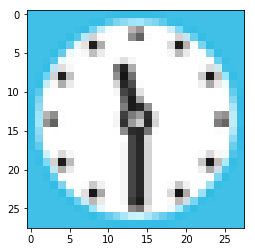

In [18]:
# The 861 images are preserved, with color!
plt.imshow(all_emoji[666].reshape(28,28,3));

In [114]:
np.random.seed(42)
random_dim = 200

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(
        1024, input_dim=2352,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(
        256, input_dim=random_dim,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(2352, activation='sigmoid'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the 
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real/not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

# Changed to return the images in addition to printing them
def plot_generated_images(epoch, generator, examples=25, dim=(5, 5),
                          figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28, 3)
 
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest') #, cmap='gray_r'
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

def make_sample_image():
    noise = np.random.normal(0, 1, size=[1, random_dim])
    generated_images = generator.predict(noise).reshape(1, 28, 28, 3)
    return generated_images

In [130]:
def train(gan, generator, discriminator, image_history, epochs=1, batch_size=30):

    # Split the training data into batches of size 128
    batch_count = all_emoji.shape[0] // batch_size
 
    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # Get a random set of input noise
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            # Get a random sampling of images from the training data
            image_batch = all_emoji[np.random.randint(0, all_emoji.shape[0],
                                                    size=batch_size)]
 
            # Generate fake emoji, equal in length to batch_size
            generated_images = generator.predict(noise)
            # Concatenate real and fake images
            X = np.concatenate([image_batch, generated_images])
            
            ## Mark real images with, fake ones with 0.9
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9
 
            # Train discriminator on this dataset of real+fake
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
 
            # Train the whole GAN on noise, while turning its
            # discriminator off (so that only the generator updates its weights).
            # This is making the generator better at fooling the discriminator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
        
        if e == 1 or e % 10 == 0:
            image_history = np.append(image_history, make_sample_image(), axis=0)
            
    return gan, generator, discriminator, image_history

In [125]:
# Build our GAN netowrk
adam = Adam(lr=0.0002, beta_1=0.5)
generator = get_generator(adam)
discriminator = get_discriminator(adam)
gan = get_gan_network(discriminator, random_dim, generator, adam)
image_history = np.zeros((1, 28, 28, 3))

In [139]:
gan, generator, discriminator, image_history = train(gan, generator, discriminator, image_history, epochs=500, batch_size=30)

 11%|█         | 3/28 [00:00<00:00, 25.24it/s]

--------------- Epoch 1 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.03it/s]

--------------- Epoch 2 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.97it/s]

--------------- Epoch 3 ---------------


 11%|█         | 3/28 [00:00<00:01, 24.79it/s]

--------------- Epoch 4 ---------------


  7%|▋         | 2/28 [00:00<00:02, 12.92it/s]

--------------- Epoch 5 ---------------


  7%|▋         | 2/28 [00:00<00:01, 18.76it/s]

--------------- Epoch 6 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.48it/s]

--------------- Epoch 7 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.61it/s]

--------------- Epoch 8 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.31it/s]

--------------- Epoch 9 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.72it/s]

--------------- Epoch 10 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.90it/s]

--------------- Epoch 11 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.68it/s]

--------------- Epoch 12 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.66it/s]

--------------- Epoch 13 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.19it/s]

--------------- Epoch 14 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.84it/s]

--------------- Epoch 15 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.08it/s]

--------------- Epoch 16 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.84it/s]

--------------- Epoch 17 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.37it/s]

--------------- Epoch 18 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.36it/s]

--------------- Epoch 19 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.96it/s]

--------------- Epoch 20 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.28it/s]

--------------- Epoch 21 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.29it/s]

--------------- Epoch 22 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.90it/s]

--------------- Epoch 23 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.55it/s]

--------------- Epoch 24 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.56it/s]

--------------- Epoch 25 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.53it/s]

--------------- Epoch 26 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.39it/s]

--------------- Epoch 27 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.43it/s]

--------------- Epoch 28 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.74it/s]

--------------- Epoch 29 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.94it/s]

--------------- Epoch 30 ---------------


 11%|█         | 3/28 [00:00<00:00, 27.06it/s]

--------------- Epoch 31 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.80it/s]

--------------- Epoch 32 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.27it/s]

--------------- Epoch 33 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.38it/s]

--------------- Epoch 34 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.41it/s]

--------------- Epoch 35 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.37it/s]

--------------- Epoch 36 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.72it/s]

--------------- Epoch 37 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.95it/s]

--------------- Epoch 38 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.52it/s]

--------------- Epoch 39 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.23it/s]

--------------- Epoch 40 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.56it/s]

--------------- Epoch 41 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.55it/s]

--------------- Epoch 42 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.53it/s]

--------------- Epoch 43 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.35it/s]

--------------- Epoch 44 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.62it/s]

--------------- Epoch 45 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.00it/s]

--------------- Epoch 46 ---------------


 11%|█         | 3/28 [00:00<00:00, 27.03it/s]

--------------- Epoch 47 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.23it/s]

--------------- Epoch 48 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.05it/s]

--------------- Epoch 49 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.39it/s]

--------------- Epoch 50 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.62it/s]

--------------- Epoch 51 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.78it/s]

--------------- Epoch 52 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.88it/s]

--------------- Epoch 53 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.01it/s]

--------------- Epoch 54 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.97it/s]

--------------- Epoch 55 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.20it/s]

--------------- Epoch 56 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.31it/s]

--------------- Epoch 57 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.26it/s]

--------------- Epoch 58 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.27it/s]

--------------- Epoch 59 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.96it/s]

--------------- Epoch 60 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.15it/s]

--------------- Epoch 61 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.21it/s]

--------------- Epoch 62 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.71it/s]

--------------- Epoch 63 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.33it/s]

--------------- Epoch 64 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.76it/s]

--------------- Epoch 65 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.92it/s]

--------------- Epoch 66 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.45it/s]

--------------- Epoch 67 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.82it/s]

--------------- Epoch 68 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.95it/s]

--------------- Epoch 69 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.68it/s]

--------------- Epoch 70 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.49it/s]

--------------- Epoch 71 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.89it/s]

--------------- Epoch 72 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.31it/s]

--------------- Epoch 73 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.88it/s]

--------------- Epoch 74 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.28it/s]

--------------- Epoch 75 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.30it/s]

--------------- Epoch 76 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.02it/s]

--------------- Epoch 77 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.06it/s]

--------------- Epoch 78 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.01it/s]

--------------- Epoch 79 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.81it/s]

--------------- Epoch 80 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.34it/s]

--------------- Epoch 81 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.88it/s]

--------------- Epoch 82 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.58it/s]

--------------- Epoch 83 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.76it/s]

--------------- Epoch 84 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.36it/s]

--------------- Epoch 85 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.27it/s]

--------------- Epoch 86 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.78it/s]

--------------- Epoch 87 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.45it/s]

--------------- Epoch 88 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.42it/s]

--------------- Epoch 89 ---------------


 11%|█         | 3/28 [00:00<00:00, 27.02it/s]

--------------- Epoch 90 ---------------


 11%|█         | 3/28 [00:00<00:00, 27.05it/s]

--------------- Epoch 91 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.50it/s]

--------------- Epoch 92 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.54it/s]

--------------- Epoch 93 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.26it/s]

--------------- Epoch 94 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.21it/s]

--------------- Epoch 95 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.42it/s]

--------------- Epoch 96 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.56it/s]

--------------- Epoch 97 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.83it/s]

--------------- Epoch 98 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.00it/s]

--------------- Epoch 99 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.16it/s]

--------------- Epoch 100 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.63it/s]

--------------- Epoch 101 ---------------


 11%|█         | 3/28 [00:00<00:01, 25.00it/s]

--------------- Epoch 102 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.10it/s]

--------------- Epoch 103 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.63it/s]

--------------- Epoch 104 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.55it/s]

--------------- Epoch 105 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.32it/s]

--------------- Epoch 106 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.65it/s]

--------------- Epoch 107 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.34it/s]

--------------- Epoch 108 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.58it/s]

--------------- Epoch 109 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.80it/s]

--------------- Epoch 110 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.66it/s]

--------------- Epoch 111 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.57it/s]

--------------- Epoch 112 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.08it/s]

--------------- Epoch 113 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.25it/s]

--------------- Epoch 114 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.50it/s]

--------------- Epoch 115 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.33it/s]

--------------- Epoch 116 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.97it/s]

--------------- Epoch 117 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.92it/s]

--------------- Epoch 118 ---------------


 11%|█         | 3/28 [00:00<00:00, 27.40it/s]

--------------- Epoch 119 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.39it/s]

--------------- Epoch 120 ---------------


 11%|█         | 3/28 [00:00<00:00, 27.10it/s]

--------------- Epoch 121 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.48it/s]

--------------- Epoch 122 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.53it/s]

--------------- Epoch 123 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.69it/s]

--------------- Epoch 124 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.99it/s]

--------------- Epoch 125 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.25it/s]

--------------- Epoch 126 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.50it/s]

--------------- Epoch 127 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.54it/s]

--------------- Epoch 128 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.56it/s]

--------------- Epoch 129 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.92it/s]

--------------- Epoch 130 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.07it/s]

--------------- Epoch 131 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.40it/s]

--------------- Epoch 132 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.85it/s]

--------------- Epoch 133 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.90it/s]

--------------- Epoch 134 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.47it/s]

--------------- Epoch 135 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.61it/s]

--------------- Epoch 136 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.64it/s]

--------------- Epoch 137 ---------------


 11%|█         | 3/28 [00:00<00:00, 27.16it/s]

--------------- Epoch 138 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.64it/s]

--------------- Epoch 139 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.24it/s]

--------------- Epoch 140 ---------------


 11%|█         | 3/28 [00:00<00:00, 27.26it/s]

--------------- Epoch 141 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.42it/s]

--------------- Epoch 142 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.70it/s]

--------------- Epoch 143 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.71it/s]

--------------- Epoch 144 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.81it/s]

--------------- Epoch 145 ---------------


 11%|█         | 3/28 [00:00<00:01, 24.85it/s]

--------------- Epoch 146 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.95it/s]

--------------- Epoch 147 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.75it/s]

--------------- Epoch 148 ---------------


 11%|█         | 3/28 [00:00<00:01, 24.70it/s]

--------------- Epoch 149 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.61it/s]

--------------- Epoch 150 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.67it/s]

--------------- Epoch 151 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.38it/s]

--------------- Epoch 152 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.22it/s]

--------------- Epoch 153 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.86it/s]

--------------- Epoch 154 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.87it/s]

--------------- Epoch 155 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.70it/s]

--------------- Epoch 156 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.53it/s]

--------------- Epoch 157 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.93it/s]

--------------- Epoch 158 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.31it/s]

--------------- Epoch 159 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.64it/s]

--------------- Epoch 160 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.50it/s]

--------------- Epoch 161 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.77it/s]

--------------- Epoch 162 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.32it/s]

--------------- Epoch 163 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.38it/s]

--------------- Epoch 164 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.67it/s]

--------------- Epoch 165 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.32it/s]

--------------- Epoch 166 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.93it/s]

--------------- Epoch 167 ---------------


 11%|█         | 3/28 [00:00<00:01, 24.75it/s]

--------------- Epoch 168 ---------------


  7%|▋         | 2/28 [00:00<00:01, 17.67it/s]

--------------- Epoch 169 ---------------


  7%|▋         | 2/28 [00:00<00:01, 15.20it/s]

--------------- Epoch 170 ---------------


 11%|█         | 3/28 [00:00<00:01, 21.77it/s]

--------------- Epoch 171 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.83it/s]

--------------- Epoch 172 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.71it/s]

--------------- Epoch 173 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.75it/s]

--------------- Epoch 174 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.93it/s]

--------------- Epoch 175 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.95it/s]

--------------- Epoch 176 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.14it/s]

--------------- Epoch 177 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.72it/s]

--------------- Epoch 178 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.81it/s]

--------------- Epoch 179 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.76it/s]

--------------- Epoch 180 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.26it/s]

--------------- Epoch 181 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.20it/s]

--------------- Epoch 182 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.65it/s]

--------------- Epoch 183 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.95it/s]

--------------- Epoch 184 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.91it/s]

--------------- Epoch 185 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.16it/s]

--------------- Epoch 186 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.02it/s]

--------------- Epoch 187 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.30it/s]

--------------- Epoch 188 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.28it/s]

--------------- Epoch 189 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.36it/s]

--------------- Epoch 190 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.00it/s]

--------------- Epoch 191 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.40it/s]

--------------- Epoch 192 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.33it/s]

--------------- Epoch 193 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.71it/s]

--------------- Epoch 194 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.77it/s]

--------------- Epoch 195 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.36it/s]

--------------- Epoch 196 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.06it/s]

--------------- Epoch 197 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.86it/s]

--------------- Epoch 198 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.12it/s]

--------------- Epoch 199 ---------------


 11%|█         | 3/28 [00:00<00:00, 27.38it/s]

--------------- Epoch 200 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.78it/s]

--------------- Epoch 201 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.38it/s]

--------------- Epoch 202 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.29it/s]

--------------- Epoch 203 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.66it/s]

--------------- Epoch 204 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.88it/s]

--------------- Epoch 205 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.12it/s]

--------------- Epoch 206 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.92it/s]

--------------- Epoch 207 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.54it/s]

--------------- Epoch 208 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.31it/s]

--------------- Epoch 209 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.24it/s]

--------------- Epoch 210 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.96it/s]

--------------- Epoch 211 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.67it/s]

--------------- Epoch 212 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.18it/s]

--------------- Epoch 213 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.93it/s]

--------------- Epoch 214 ---------------


 11%|█         | 3/28 [00:00<00:01, 24.85it/s]

--------------- Epoch 215 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.66it/s]

--------------- Epoch 216 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.19it/s]

--------------- Epoch 217 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.09it/s]

--------------- Epoch 218 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.79it/s]

--------------- Epoch 219 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.95it/s]

--------------- Epoch 220 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.57it/s]

--------------- Epoch 221 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.58it/s]

--------------- Epoch 222 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.66it/s]

--------------- Epoch 223 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.12it/s]

--------------- Epoch 224 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.43it/s]

--------------- Epoch 225 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.13it/s]

--------------- Epoch 226 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.83it/s]

--------------- Epoch 227 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.24it/s]

--------------- Epoch 228 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.44it/s]

--------------- Epoch 229 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.86it/s]

--------------- Epoch 230 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.15it/s]

--------------- Epoch 231 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.69it/s]

--------------- Epoch 232 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.05it/s]

--------------- Epoch 233 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.08it/s]

--------------- Epoch 234 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.10it/s]

--------------- Epoch 235 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.16it/s]

--------------- Epoch 236 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.09it/s]

--------------- Epoch 237 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.92it/s]

--------------- Epoch 238 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.12it/s]

--------------- Epoch 239 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.10it/s]

--------------- Epoch 240 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.41it/s]

--------------- Epoch 241 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.75it/s]

--------------- Epoch 242 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.63it/s]

--------------- Epoch 243 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.17it/s]

--------------- Epoch 244 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.53it/s]

--------------- Epoch 245 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.05it/s]

--------------- Epoch 246 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.77it/s]

--------------- Epoch 247 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.94it/s]

--------------- Epoch 248 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.54it/s]

--------------- Epoch 249 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.93it/s]

--------------- Epoch 250 ---------------


 11%|█         | 3/28 [00:00<00:00, 27.23it/s]

--------------- Epoch 251 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.74it/s]

--------------- Epoch 252 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.33it/s]

--------------- Epoch 253 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.10it/s]

--------------- Epoch 254 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.07it/s]

--------------- Epoch 255 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.45it/s]

--------------- Epoch 256 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.47it/s]

--------------- Epoch 257 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.01it/s]

--------------- Epoch 258 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.18it/s]

--------------- Epoch 259 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.59it/s]

--------------- Epoch 260 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.08it/s]

--------------- Epoch 261 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.07it/s]

--------------- Epoch 262 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.38it/s]

--------------- Epoch 263 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.94it/s]

--------------- Epoch 264 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.85it/s]

--------------- Epoch 265 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.42it/s]

--------------- Epoch 266 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.40it/s]

--------------- Epoch 267 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.54it/s]

--------------- Epoch 268 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.07it/s]

--------------- Epoch 269 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.11it/s]

--------------- Epoch 270 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.86it/s]

--------------- Epoch 271 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.81it/s]

--------------- Epoch 272 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.51it/s]

--------------- Epoch 273 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.26it/s]

--------------- Epoch 274 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.30it/s]

--------------- Epoch 275 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.11it/s]

--------------- Epoch 276 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.34it/s]

--------------- Epoch 277 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.67it/s]

--------------- Epoch 278 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.95it/s]

--------------- Epoch 279 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.40it/s]

--------------- Epoch 280 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.40it/s]

--------------- Epoch 281 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.45it/s]

--------------- Epoch 282 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.65it/s]

--------------- Epoch 283 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.37it/s]

--------------- Epoch 284 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.69it/s]

--------------- Epoch 285 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.57it/s]

--------------- Epoch 286 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.81it/s]

--------------- Epoch 287 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.71it/s]

--------------- Epoch 288 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.99it/s]

--------------- Epoch 289 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.80it/s]

--------------- Epoch 290 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.20it/s]

--------------- Epoch 291 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.95it/s]

--------------- Epoch 292 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.82it/s]

--------------- Epoch 293 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.76it/s]

--------------- Epoch 294 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.59it/s]

--------------- Epoch 295 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.08it/s]

--------------- Epoch 296 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.52it/s]

--------------- Epoch 297 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.91it/s]

--------------- Epoch 298 ---------------


 11%|█         | 3/28 [00:00<00:00, 27.16it/s]

--------------- Epoch 299 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.77it/s]

--------------- Epoch 300 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.02it/s]

--------------- Epoch 301 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.24it/s]

--------------- Epoch 302 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.94it/s]

--------------- Epoch 303 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.57it/s]

--------------- Epoch 304 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.17it/s]

--------------- Epoch 305 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.65it/s]

--------------- Epoch 306 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.35it/s]

--------------- Epoch 307 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.61it/s]

--------------- Epoch 308 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.69it/s]

--------------- Epoch 309 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.19it/s]

--------------- Epoch 310 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.96it/s]

--------------- Epoch 311 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.63it/s]

--------------- Epoch 312 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.72it/s]

--------------- Epoch 313 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.18it/s]

--------------- Epoch 314 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.11it/s]

--------------- Epoch 315 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.50it/s]

--------------- Epoch 316 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.13it/s]

--------------- Epoch 317 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.57it/s]

--------------- Epoch 318 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.97it/s]

--------------- Epoch 319 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.88it/s]

--------------- Epoch 320 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.93it/s]

--------------- Epoch 321 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.31it/s]

--------------- Epoch 322 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.70it/s]

--------------- Epoch 323 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.06it/s]

--------------- Epoch 324 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.85it/s]

--------------- Epoch 325 ---------------


  7%|▋         | 2/28 [00:00<00:01, 14.36it/s]

--------------- Epoch 326 ---------------


 11%|█         | 3/28 [00:00<00:01, 24.67it/s]

--------------- Epoch 327 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.16it/s]

--------------- Epoch 328 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.15it/s]

--------------- Epoch 329 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.06it/s]

--------------- Epoch 330 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.79it/s]

--------------- Epoch 331 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.12it/s]

--------------- Epoch 332 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.33it/s]

--------------- Epoch 333 ---------------


  7%|▋         | 2/28 [00:00<00:01, 15.06it/s]

--------------- Epoch 334 ---------------


 11%|█         | 3/28 [00:00<00:01, 20.35it/s]

--------------- Epoch 335 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.74it/s]

--------------- Epoch 336 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.82it/s]

--------------- Epoch 337 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.98it/s]

--------------- Epoch 338 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.24it/s]

--------------- Epoch 339 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.20it/s]

--------------- Epoch 340 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.68it/s]

--------------- Epoch 341 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.71it/s]

--------------- Epoch 342 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.64it/s]

--------------- Epoch 343 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.79it/s]

--------------- Epoch 344 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.58it/s]

--------------- Epoch 345 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.44it/s]

--------------- Epoch 346 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.61it/s]

--------------- Epoch 347 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.81it/s]

--------------- Epoch 348 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.19it/s]

--------------- Epoch 349 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.74it/s]

--------------- Epoch 350 ---------------


 11%|█         | 3/28 [00:00<00:00, 27.22it/s]

--------------- Epoch 351 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.57it/s]

--------------- Epoch 352 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.40it/s]

--------------- Epoch 353 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.17it/s]

--------------- Epoch 354 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.11it/s]

--------------- Epoch 355 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.12it/s]

--------------- Epoch 356 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.09it/s]

--------------- Epoch 357 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.81it/s]

--------------- Epoch 358 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.39it/s]

--------------- Epoch 359 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.67it/s]

--------------- Epoch 360 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.34it/s]

--------------- Epoch 361 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.22it/s]

--------------- Epoch 362 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.73it/s]

--------------- Epoch 363 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.24it/s]

--------------- Epoch 364 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.98it/s]

--------------- Epoch 365 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.58it/s]

--------------- Epoch 366 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.16it/s]

--------------- Epoch 367 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.72it/s]

--------------- Epoch 368 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.93it/s]

--------------- Epoch 369 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.73it/s]

--------------- Epoch 370 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.33it/s]

--------------- Epoch 371 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.70it/s]

--------------- Epoch 372 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.35it/s]

--------------- Epoch 373 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.14it/s]

--------------- Epoch 374 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.71it/s]

--------------- Epoch 375 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.22it/s]

--------------- Epoch 376 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.03it/s]

--------------- Epoch 377 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.25it/s]

--------------- Epoch 378 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.55it/s]

--------------- Epoch 379 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.18it/s]

--------------- Epoch 380 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.20it/s]

--------------- Epoch 381 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.50it/s]

--------------- Epoch 382 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.71it/s]

--------------- Epoch 383 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.67it/s]

--------------- Epoch 384 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.00it/s]

--------------- Epoch 385 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.19it/s]

--------------- Epoch 386 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.16it/s]

--------------- Epoch 387 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.31it/s]

--------------- Epoch 388 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.88it/s]

--------------- Epoch 389 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.63it/s]

--------------- Epoch 390 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.52it/s]

--------------- Epoch 391 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.50it/s]

--------------- Epoch 392 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.54it/s]

--------------- Epoch 393 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.11it/s]

--------------- Epoch 394 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.91it/s]

--------------- Epoch 395 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.36it/s]

--------------- Epoch 396 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.04it/s]

--------------- Epoch 397 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.09it/s]

--------------- Epoch 398 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.53it/s]

--------------- Epoch 399 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.14it/s]

--------------- Epoch 400 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.80it/s]

--------------- Epoch 401 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.15it/s]

--------------- Epoch 402 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.49it/s]

--------------- Epoch 403 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.78it/s]

--------------- Epoch 404 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.98it/s]

--------------- Epoch 405 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.36it/s]

--------------- Epoch 406 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.52it/s]

--------------- Epoch 407 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.64it/s]

--------------- Epoch 408 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.36it/s]

--------------- Epoch 409 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.44it/s]

--------------- Epoch 410 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.82it/s]

--------------- Epoch 411 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.13it/s]

--------------- Epoch 412 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.36it/s]

--------------- Epoch 413 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.52it/s]

--------------- Epoch 414 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.58it/s]

--------------- Epoch 415 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.93it/s]

--------------- Epoch 416 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.35it/s]

--------------- Epoch 417 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.50it/s]

--------------- Epoch 418 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.20it/s]

--------------- Epoch 419 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.23it/s]

--------------- Epoch 420 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.85it/s]

--------------- Epoch 421 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.98it/s]

--------------- Epoch 422 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.25it/s]

--------------- Epoch 423 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.54it/s]

--------------- Epoch 424 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.03it/s]

--------------- Epoch 425 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.42it/s]

--------------- Epoch 426 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.21it/s]

--------------- Epoch 427 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.14it/s]

--------------- Epoch 428 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.21it/s]

--------------- Epoch 429 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.31it/s]

--------------- Epoch 430 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.60it/s]

--------------- Epoch 431 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.89it/s]

--------------- Epoch 432 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.83it/s]

--------------- Epoch 433 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.43it/s]

--------------- Epoch 434 ---------------


 11%|█         | 3/28 [00:00<00:01, 23.06it/s]

--------------- Epoch 435 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.55it/s]

--------------- Epoch 436 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.96it/s]

--------------- Epoch 437 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.98it/s]

--------------- Epoch 438 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.76it/s]

--------------- Epoch 439 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.26it/s]

--------------- Epoch 440 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.38it/s]

--------------- Epoch 441 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.30it/s]

--------------- Epoch 442 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.14it/s]

--------------- Epoch 443 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.20it/s]

--------------- Epoch 444 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.26it/s]

--------------- Epoch 445 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.29it/s]

--------------- Epoch 446 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.13it/s]

--------------- Epoch 447 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.01it/s]

--------------- Epoch 448 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.91it/s]

--------------- Epoch 449 ---------------


 11%|█         | 3/28 [00:00<00:01, 25.00it/s]

--------------- Epoch 450 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.52it/s]

--------------- Epoch 451 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.02it/s]

--------------- Epoch 452 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.72it/s]

--------------- Epoch 453 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.00it/s]

--------------- Epoch 454 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.30it/s]

--------------- Epoch 455 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.12it/s]

--------------- Epoch 456 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.72it/s]

--------------- Epoch 457 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.21it/s]

--------------- Epoch 458 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.09it/s]

--------------- Epoch 459 ---------------


 11%|█         | 3/28 [00:00<00:01, 24.57it/s]

--------------- Epoch 460 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.67it/s]

--------------- Epoch 461 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.82it/s]

--------------- Epoch 462 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.82it/s]

--------------- Epoch 463 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.34it/s]

--------------- Epoch 464 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.72it/s]

--------------- Epoch 465 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.40it/s]

--------------- Epoch 466 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.90it/s]

--------------- Epoch 467 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.48it/s]

--------------- Epoch 468 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.09it/s]

--------------- Epoch 469 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.75it/s]

--------------- Epoch 470 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.32it/s]

--------------- Epoch 471 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.70it/s]

--------------- Epoch 472 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.07it/s]

--------------- Epoch 473 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.82it/s]

--------------- Epoch 474 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.90it/s]

--------------- Epoch 475 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.10it/s]

--------------- Epoch 476 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.83it/s]

--------------- Epoch 477 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.61it/s]

--------------- Epoch 478 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.15it/s]

--------------- Epoch 479 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.26it/s]

--------------- Epoch 480 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.93it/s]

--------------- Epoch 481 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.16it/s]

--------------- Epoch 482 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.04it/s]

--------------- Epoch 483 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.13it/s]

--------------- Epoch 484 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.67it/s]

--------------- Epoch 485 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.70it/s]

--------------- Epoch 486 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.43it/s]

--------------- Epoch 487 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.59it/s]

--------------- Epoch 488 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.73it/s]

--------------- Epoch 489 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.96it/s]

--------------- Epoch 490 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.04it/s]

--------------- Epoch 491 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.41it/s]

--------------- Epoch 492 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.40it/s]

--------------- Epoch 493 ---------------


 11%|█         | 3/28 [00:00<00:00, 25.84it/s]

--------------- Epoch 494 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.31it/s]

--------------- Epoch 495 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.70it/s]

--------------- Epoch 496 ---------------


 11%|█         | 3/28 [00:00<00:01, 18.00it/s]

--------------- Epoch 497 ---------------


  7%|▋         | 2/28 [00:00<00:01, 15.77it/s]

--------------- Epoch 498 ---------------


  7%|▋         | 2/28 [00:00<00:01, 17.90it/s]

--------------- Epoch 499 ---------------


 11%|█         | 3/28 [00:00<00:00, 26.05it/s]

--------------- Epoch 500 ---------------


100%|██████████| 28/28 [00:01<00:00, 25.72it/s]


Print out one example from every 10 epochs.

Epoch 0


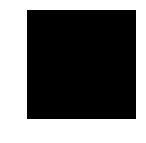

Epoch 10


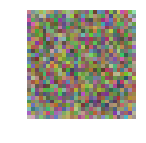

Epoch 20


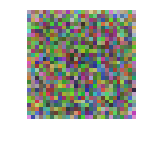

Epoch 30


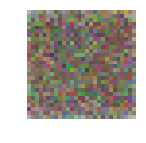

Epoch 40


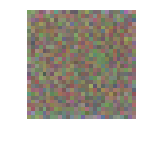

Epoch 50


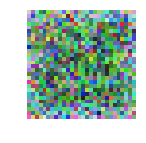

Epoch 60


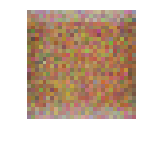

Epoch 70


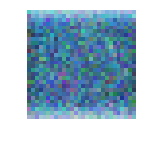

Epoch 80


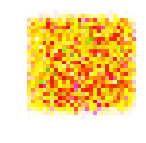

Epoch 90


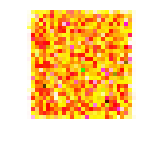

Epoch 100


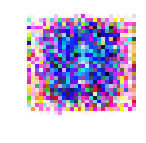

Epoch 110


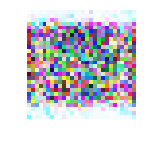

Epoch 120


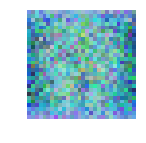

Epoch 130


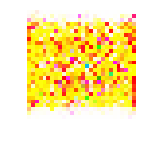

Epoch 140


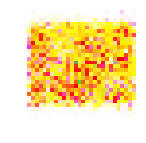

Epoch 150


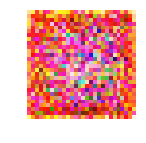

Epoch 160


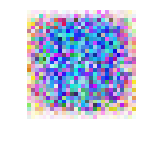

Epoch 170


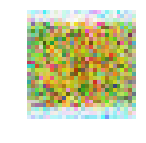

Epoch 180


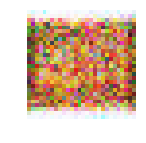

Epoch 190


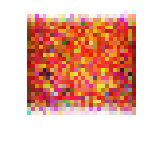

Epoch 200


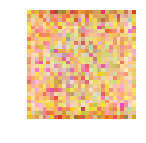

Epoch 210


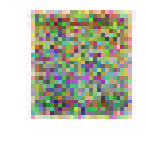

Epoch 220


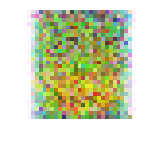

Epoch 230


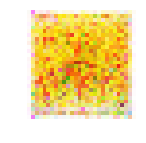

Epoch 240


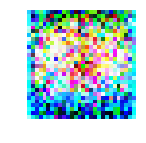

Epoch 250


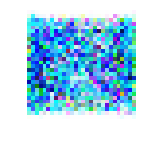

Epoch 260


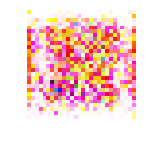

Epoch 270


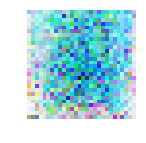

Epoch 280


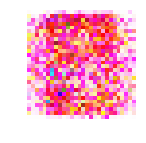

Epoch 290


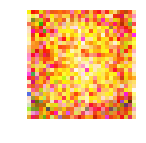

Epoch 300


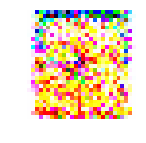

Epoch 310


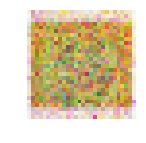

Epoch 320


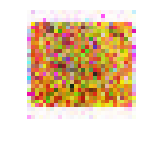

Epoch 330


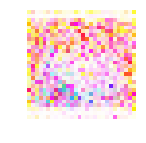

Epoch 340


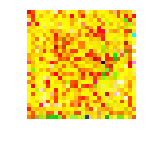

Epoch 350


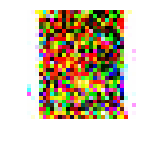

Epoch 360


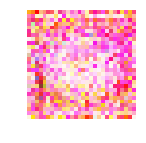

Epoch 370


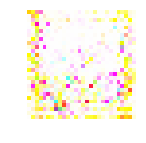

Epoch 380


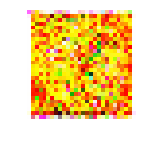

Epoch 390


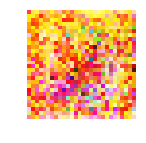

Epoch 400


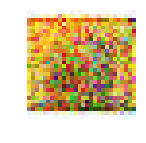

Epoch 410


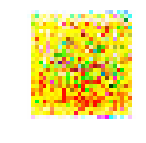

Epoch 420


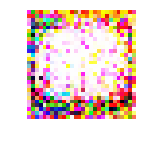

Epoch 430


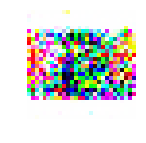

Epoch 440


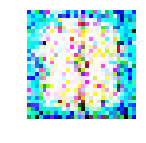

Epoch 450


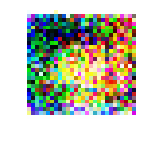

Epoch 460


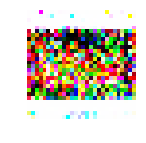

Epoch 470


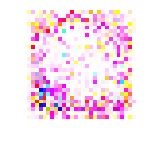

Epoch 480


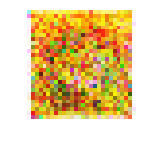

Epoch 490


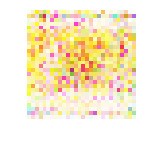

Epoch 500


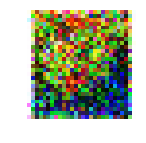

Epoch 510


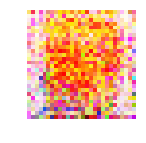

Epoch 520


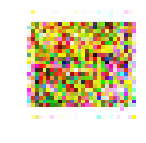

Epoch 530


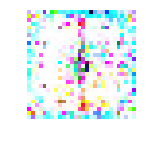

Epoch 540


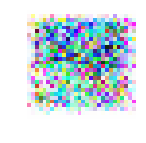

Epoch 550


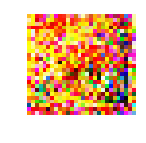

Epoch 560


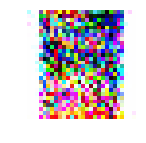

Epoch 570


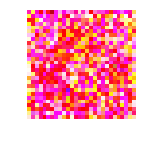

Epoch 580


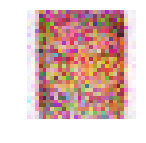

Epoch 590


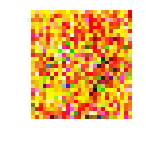

Epoch 600


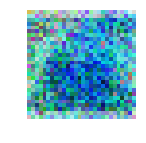

Epoch 610


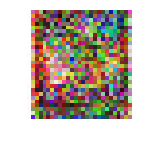

Epoch 620


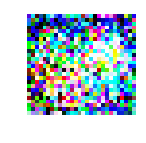

Epoch 630


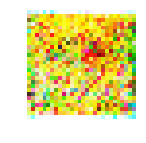

Epoch 640


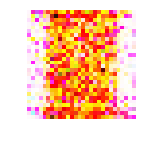

Epoch 650


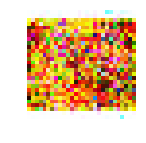

Epoch 660


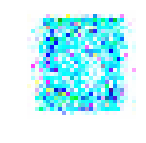

Epoch 670


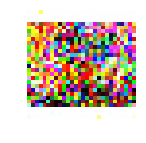

Epoch 680


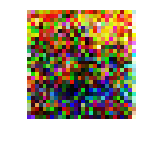

In [141]:
def plot_from_history(image_history, figsize=(2, 2)):
    
    for i in range(image_history.shape[0]):
        print(f'Epoch {i*10}')
        plt.figure(figsize=figsize);
        plt.imshow(image_history[i], interpolation='nearest')
        plt.axis('off')
        plt.show();
        
plot_from_history(image_history);

**Your goal** - *train a GAN that makes new emoji!*

The good news - the data is naturally 28x28, which is the same size as the earlier example (resulting in an input layer size of $28 \times 28=784$). It's big enough to kinda look like a thing, but small enough to be feasible to train with limited resources.

The bad news - the emoji are 4 layer PNGs (RGBA), and grayscale conversion is inconsistent at best (the above looks pretty good, but experiment and you'll see). It's OK to convert to grayscale and train that way to start (since it'll pretty much drop in to the example code with minimal modification), but you may want to see if you can figure out handling all 4 layers of the input image (basically - growing the dimensionality of the data).

The worse news - this dataset may not be large enough to get the same quality of results as MNIST. The resources/stretch goals section links to additional sources, so feel free to get creative (and practice your scraping/ingest skills) - but, it is suggested to do so only *after* working some with this as a starting point.

*Hint* - the main challenge in getting an MVP running will just be loading and converting all the images. [os.listdir](https://docs.python.org/3.7/library/os.html#os.listdir) plus a loop, and refactoring the image processing code into a function, should go a long way.

# Resources and Stretch Goals

Stretch goals
- [emoji-data](https://github.com/iamcal/emoji-data) - more, bigger, emoji
- [Slackmojis](https://slackmojis.com) - even more - many of them animated, which would be a significant additional challenge (probably not something for a day)

Resources
- [StyleGAN Explained](https://towardsdatascience.com/explained-a-style-based-generator-architecture-for-gans-generating-and-tuning-realistic-6cb2be0f431) - blog post describing GANs and StyleGAN in particular
- [Implementing GANs in TensorFlow](https://blog.paperspace.com/implementing-gans-in-tensorflow/) - blog post showing TF implementation of a simple GAN
- [Training GANs using Google Colaboratory](https://towardsdatascience.com/training-gans-using-google-colaboratory-f91d4e6f61fe) - an approach using Torch and GPU instances
- [Gym](https://gym.openai.com) - a toolkit for reinforcement learning, another innovative ML approach
- [deep emoji generative adversarial network](https://github.com/anoff/deep-emoji-gan) - yes, the idea of an emoji GAN has been done - so check out this extended analysis of the results
- [DeepMoji](http://deepmoji.mit.edu) - not a GAN, but a cool application of deep learning to emoji